In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,LeaveOneOut,KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression,Ridge,RidgeCV,Lasso,LassoCV,ElasticNet,ElasticNetCV,LogisticRegression,LassoLars,LassoLarsCV,LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

Import Data: Each row represent a dog sample, the meth_matrix is shows the methylation level
And start preprocessing

In [8]:
meth_matrix=pd.read_csv('/Users/yuyanyan/Downloads/CanineMatnoNaN.csv')
targets=pd.read_excel('/Users/yuyanyan/Desktop/dogproject/CGmapfiles.xlsx')
display(meth_matrix.head(3)) # Features
display(targets.head(3)) # Targets

,0,2,4,5,6,7,8,9,10,14,...,5590,5591,5592,5595,5596,5600,5602,5605,5606,5607
0,DogWolf00108_S84.CGmap,0.922865,0.075306,0.043478,0.126910,0.161389,0.096330,0.032172,0.051988,0.054773,...,0.027184,0.666667,0.785997,0.793282,0.826855,0.757333,0.844444,0.634021,0.789855,0.817610
1,DogWolf00109_S110.CGmap,0.930716,0.031250,0.083333,0.171190,0.184746,0.122419,0.018196,0.020033,0.030960,...,0.008547,0.603175,0.811429,0.794643,0.800000,0.673820,0.838951,0.626866,0.765625,0.890411
2,DogWolf00110_S105.CGmap,0.916096,0.073529,0.030075,0.153103,0.293263,0.174194,0.057586,0.046768,0.023041,...,0.040268,0.721154,0.807107,0.726804,0.756696,0.850187,0.798144,0.761905,0.773913,0.811927


,filename,sampleid,breed,age,sex,weight,spayed/neutered,DOB,Acquisition Date,Unnamed: 9,dogs details
0,DogWolf00108_S84.CGmap,31019101710432,Miniature Schnauzer,NaN,FEMALE,16 lbs,Yes,NaT,NaT,NaN,NaN
1,DogWolf00109_S110.CGmap,31201050607833,English Springer Spaniel,6.8,FEMALE,35 lbs,Yes,NaT,NaT,NaN,NaN
2,DogWolf00110_S105.CGmap,31201050607826,English Springer Spaniel,12.9,FEMALE,45 lbs,Yes,NaT,NaT,NaN,NaN


In [11]:
display(targets.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   filename          217 non-null    object        
 1   sampleid          217 non-null    object        
 2   breed             217 non-null    object        
 3   age               216 non-null    float64       
 4   sex               161 non-null    object        
 5   weight            152 non-null    object        
 6   spayed/neutered   149 non-null    object        
 7   DOB               56 non-null     datetime64[ns]
 8   Acquisition Date  56 non-null     datetime64[ns]
 9   Unnamed: 9        0 non-null      float64       
 10  dogs details      0 non-null      float64       
dtypes: datetime64[ns](2), float64(3), object(6)
memory usage: 18.8+ KB


None

Interested in predicting age with methylation pattern

In [15]:
age=pd.DataFrame(data={'filename':targets['filename'],'age':targets['age']})
display(age)

,filename,age
0,DogWolf00108_S84.CGmap,NaN
1,DogWolf00109_S110.CGmap,6.8
2,DogWolf00110_S105.CGmap,12.9
3,DogWolf00111_S89.CGmap,5.6
4,DogWolf00112_S88.CGmap,1.1
...,...,...
212,PK9-31201050607830.CGmap,11.8
213,PK9-31201050607843.CGmap,1.0
214,PK9-31201050607844.CGmap,2.3
215,PK9-31301050607662.CGmap,1.7


See if theres' nan values

In [17]:
age['age'].isnull().values.any()

True

In [18]:
age['age'].isnull().sum()

1

Match the rows of age to the methylation matrix

In [20]:
select=[]
for i in meth_matrix.iloc[:,0]:
    for j in age['filename']:
        if i==j:
            select.append(i)
count=0            
for i in age['filename']:
    if i not in select:
        age.drop(count,axis=0,inplace=True)
    count+=1
    
meth_matrix=meth_matrix.sort_values(by='0')
age=age.sort_values(by='filename')

Remove sample with nan value

In [33]:
age['age']=age['age'].astype(str)
drop=[]
count=0
for i in age['age']:
    if i=='nan':
        drop.append(age.iloc[count,0])
    count+=1
for i in meth_matrix['0']:
    if i in drop:
        indexNames = meth_matrix[ meth_matrix['0'] == i ].index
        meth_matrix.drop(indexNames,axis=0,inplace=True)
        
for i in age['filename']:
    if i in drop:
        indexNames = age[ age['filename'] == i ].index
        age.drop(indexNames,axis=0,inplace=True)

In [59]:
age['age']=age['age'].astype('float64')
meth_matrix.shape,age.shape

((206, 2421), (206, 2))

Information about the age

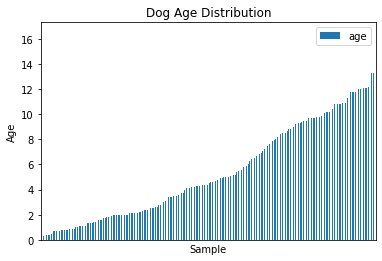

In [79]:
sorted_age=age.copy()
sorted_age.sort_values(by='age',inplace=True)
sorted_age.plot(x='filename', y='age', kind='bar',title="Dog Age Distribution", ylabel="Age", xlabel="Sample")
ax=plt.gca()
ax.axes.xaxis.set_ticks([])
plt.show()

In [77]:
lowest = sorted_age.iloc[0,:]['age']
lowest_filename = sorted_age.iloc[0,:]['filename']

highest = sorted_age.iloc[-1,:]['age']
highest_filename = sorted_age.iloc[-1,:]['filename']

average_age= sorted_age["age"].mean()

print("Lowest age sample is {} , {} years old ; Highest age sample is {}, {} years old".format(lowest_filename, lowest, highest_filename, highest))
print("\nAverage is {} years old".format(round(average_age,2)))

Lowest age sample is DogWolf27915_S67.CGmap , 0.0 years old ; Highest age sample is DogWolf00120_S102.CGmap, 16.5 years old

Average is 5.4 years old


## Remove outlier step, function from https://colinpfarrell.com/tag-ec-tutorial/ , with modification

In [80]:
def new_plot_outliers(originalDataframe, PhenotypeMat):#exclude outliers from data, first input is MethylMatrix, second is AgeMatrix
    dogMatrixarr = np.array(originalDataframe.drop(['0'], axis=1))
    dogMatrixarr = dogMatrixarr.astype('float64')
    
    Mat_labels = originalDataframe['0']
    Phenotypesarr = PhenotypeMat['age']
    
    qc_pca=PCA(n_components=4, whiten=False)
    qc_pca_vals = qc_pca.fit_transform(dogMatrixarr)
    variance_explained= qc_pca.explained_variance_ratio_
    pc1 = qc_pca_vals[:,0]
    pc2 = qc_pca_vals[:,1]
        
    non_outlier_features=[]
    non_outlier_targets=[]
    fig, ax = plt.subplots(figsize=(12,12))
    ax.scatter(pc1, pc2,)
    ax.set_title('Methylation Matrix PCA')
    ax.set_xlabel(f'PC1 Variance Explained = {variance_explained[0]:0.3f}')
    ax.set_ylabel(f'PC2 Variance Explained = {variance_explained[1]:0.3f}')
    for x, y, label, targets in zip(pc1, pc2, Mat_labels, Phenotypesarr):
        ax.text(x=x, y=y, s=None)
        if x < 5:
            non_outlier_features.append(label)
            non_outlier_targets.append(targets)
    plt.show()
    
    index = originalDataframe.index
    counter = 0
    nonmatch = []
    for i in originalDataframe['0']:
        match = False
        for j in non_outlier_features:
            if i==j:
                match = True
                break
        if match == False:
            nonmatch.append(index[counter])
        counter+=1
    
    originalDataframeP = originalDataframe.drop(nonmatch)
    non_outlier_features = np.array(originalDataframeP.drop(['0'], axis=1))
    non_outlier_features = non_outlier_features.astype('float64')
    non_outlier_targets = np.array(non_outlier_targets)
    non_outlier_targets=non_outlier_targets.astype('float64')
    
    return (non_outlier_features, non_outlier_targets)

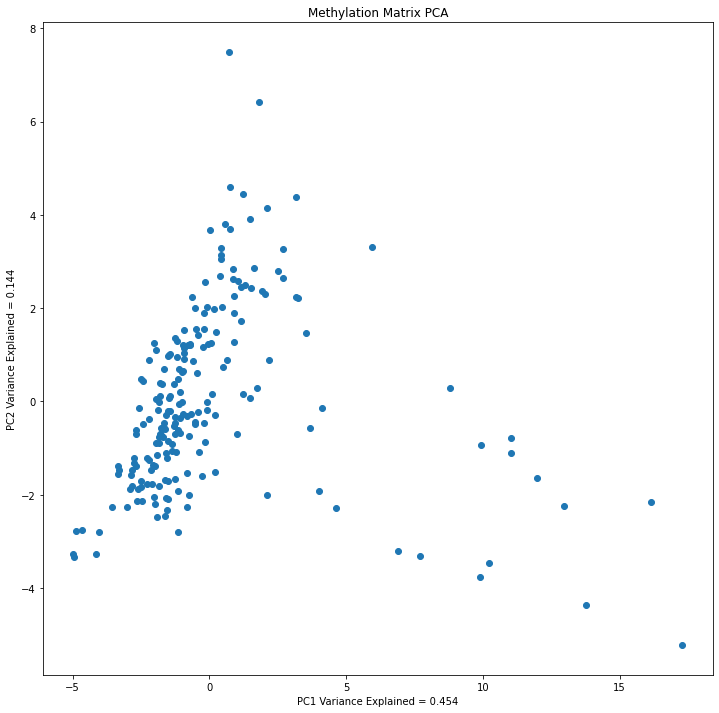

In [83]:
non_outlier_feature, non_outlier_age=new_plot_outliers(meth_matrix,age)

In [84]:
print(non_outlier_feature.shape)
print(non_outlier_age.shape)

(192, 2420)
(192,)


Model

## Regression Models

In [93]:
lasso_cv=LassoCV(cv=10, n_jobs=-1).fit(non_outlier_feature, non_outlier_age)
ridge_cv=RidgeCV(scoring = 'neg_mean_absolute_error').fit(non_outlier_feature, non_outlier_age)
Llars_cv=LassoLarsCV(cv = 10, n_jobs=-1).fit(non_outlier_feature, non_outlier_age)
elasticnet_cv=ElasticNetCV(cv=10,n_jobs=-1).fit(non_outlier_feature, non_outlier_age)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=7.478e-03, with an active set of 73 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.72915761258529, tolerance: 0.28538434377852867
  model = cd_fast.enet_coordinate_descent(


In [118]:
models=[]
models.append((Lasso,lasso_cv))
models.append((Ridge,ridge_cv))
models.append((LassoLars,Llars_cv))
models.append((ElasticNet,elasticnet_cv))

In [107]:
for name, model in models:
    model_name = model.__class__.__name__
    m_alpha=model.alpha_
    score=cross_val_score(name(alpha=m_alpha), non_outlier_feature, non_outlier_age, scoring='neg_mean_absolute_error', cv = LeaveOneOut(), n_jobs=-1 )
    score=np.absolute(score)
    mean_absolute_error = np.mean(score)

    #prediction
    predictions = cross_val_predict(name(alpha =m_alpha), non_outlier_feature, non_outlier_age, cv = LeaveOneOut(), n_jobs=-1)
    correlation_coef = np.corrcoef(predictions, non_outlier_age)[0,1]
    print(model_name + ": ")
    print("-" * 10)
    print('MAE is %.3f with a standard deviation of %.3f.' % (mean_absolute_error, np.std(score)))
    print('Correlation coefficient is %.3f' % (correlation_coef))
    print("-" * 30)

LassoCV: 
----------
MAE is 1.349 with a standard deviation of 1.190.
Correlation coefficient is 0.885
------------------------------
RidgeCV: 
----------
MAE is 1.236 with a standard deviation of 1.106.
Correlation coefficient is 0.904
------------------------------
LassoLarsCV: 
----------
MAE is 1.126 with a standard deviation of 0.991.
Correlation coefficient is 0.921
------------------------------
ElasticNetCV: 
----------
MAE is 1.247 with a standard deviation of 1.093.
Correlation coefficient is 0.904
------------------------------


## Comparison

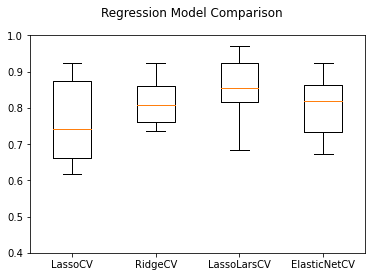

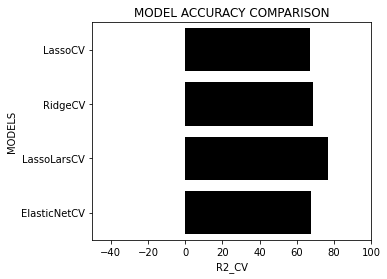

In [142]:
results=[]
names=[]
comparison = pd.DataFrame(columns=["Models","r2_cv"])

for name, model in models:
    model_name = model.__class__.__name__
    m_alpha=model.alpha_
    score=cross_val_score(name(alpha=m_alpha), non_outlier_feature, non_outlier_age, scoring='r2', cv =10,n_jobs=-1)
    results.append(score)
    names.append(model_name)
    r2_cv=score.mean()
    r2cv_result = pd.DataFrame([[model_name,r2_cv*100]],columns=["Models","r2_cv"])
    comparison=comparison.append(r2cv_result)
    
#Comparison1
fig = plt.figure()
fig.suptitle('Regression Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.ylim(0.4,1)
ax.set_xticklabels(names)
plt.show()

#Comparison2
figure = plt.figure(figsize=(5,4))   
sns.barplot(x="r2_cv",y="Models",data=comparison,color="k")
plt.xlabel("R2_CV")
plt.ylabel("MODELS")
plt.xlim(-50,100)
plt.title("MODEL ACCURACY COMPARISON")
plt.show()

Ridge and LassoLars performs well

## Plot regression for Ridge and LassoLars, function from https://colinpfarrell.com/tag-ec-tutorial/ , with modification

In [168]:
def plot_model(name,model,feature,target):
    if(model==RidgeCV):
        cv=model(scoring='neg_mean_absolute_error')
    else:
        cv=model(cv=10, n_jobs=-1)
    fitting=cv.fit(feature, target)
    m_alpha = fitting.alpha_
    score= cross_val_score(name(alpha=m_alpha), feature, target, scoring='neg_mean_absolute_error', cv = LeaveOneOut(), n_jobs=-1 )
    m_score = np.absolute(score)
    mean_absolute_error = np.mean(m_score)
    predictions = cross_val_predict(name(alpha = m_alpha), feature, target, cv = LeaveOneOut(), n_jobs=-1)
    correlation_coef = np.corrcoef(predictions, target)[0,1]
    
    fig, ax = plt.subplots(figsize=(12,12))

    ax.scatter(predictions, target, c=sns.color_palette("Paired")[3])
    ax.plot([np.asarray(target).min(), np.asarray(target).max()],
    [np.asarray(target).min(), np.asarray(target).max()], 'k--', lw=2)
    ax.set_xlabel('Predicted Age (years)')
    ax.set_ylabel('Actual Age (years)')
    model_name = name.__name__
    ax.set_title('Cross Validation for {0} Regression Model'.format(model_name))
    ax.text(0.01, .98, f'Correlation Coefficient = {correlation_coef:0.2f}',  transform=ax.transAxes)
    ax.text(0.01, .96, f'MAE = {mean_absolute_error:0.2f} (years)',  transform=ax.transAxes)
    ax.text(0.01, .94, f'Alpha = {m_alpha:0.2f}',  transform=ax.transAxes)

    plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


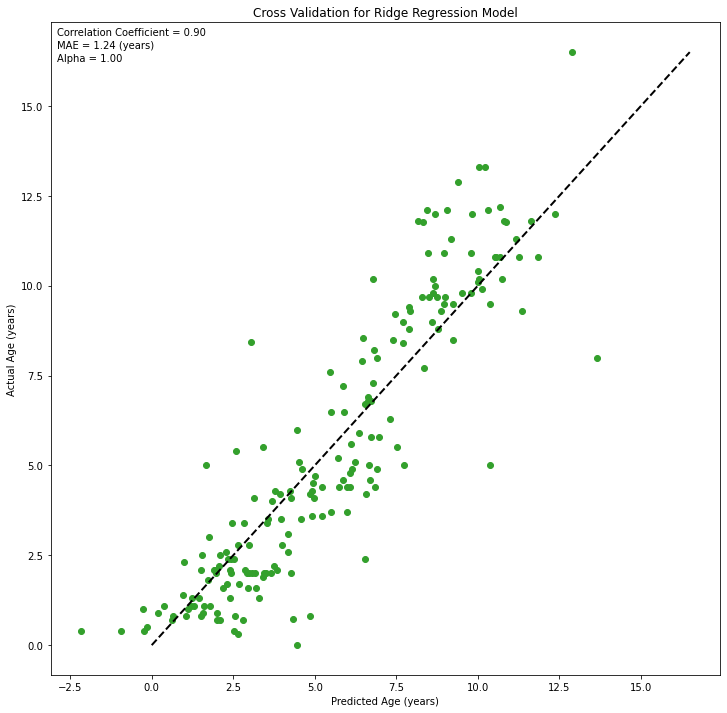

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:571: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 89 iterations, i.e. alpha=7.478e-03, with an active set of 73 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


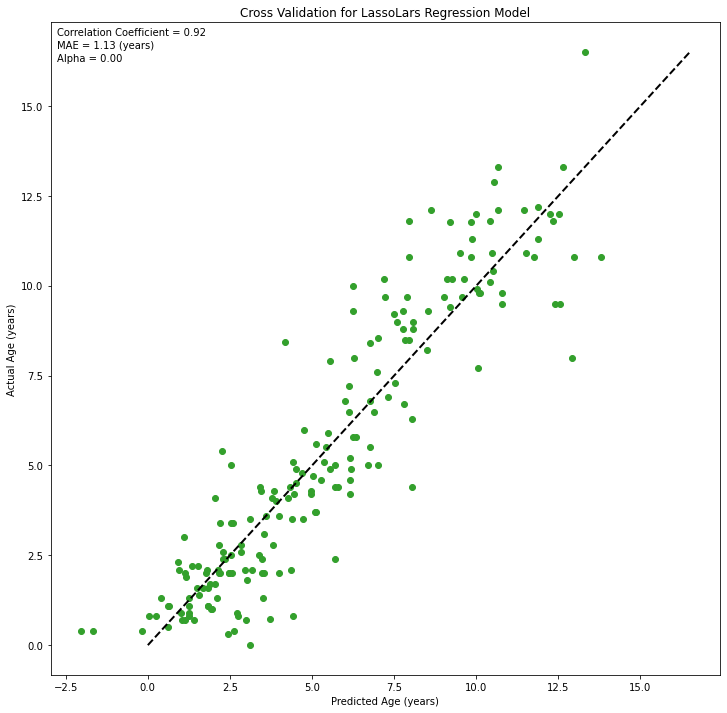

In [171]:
plot_model(Ridge,RidgeCV,non_outlier_feature,non_outlier_age)
plot_model(LassoLars,LassoLarsCV,non_outlier_feature,non_outlier_age)